# Modeling with Decision Trees
This notebook covers examples that employ decision trees.

## Predicting Signups
Sometimes when a high-traffic site links to a new application that offers free accounts and subscription accounts, the application will get thousands of new users. Many of these users are driven by curiosity and are not really looking for that particular type of application, so there is a low likelihood that they will become paying customers. This makes it difficult to distinguish and follow up with likely customers, so many sites report to mass-emailing everyone who has signed up, rather than using a more targeted approach. 

To help with this problem, it would be useful to be able to predict the likelihood that a user will become a paying customer, and the factors that indicate if a user will become a customer. The former information can be used to guide an advertisement strategy and to make certain aspects of the site more accessible.  

In [1]:
# ! conda install graphviz

In [2]:
import numpy as np
import pandas as pd
import math

In [3]:
from sklearn.datasets import load_iris
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import graphviz 

In [4]:
predict_df  = pd.read_csv("PredictingSignupsTrain.csv")

target_column = 'Service_Chosen'

Question 1. Get an array with the names of all columns. Exclude the target.

In [5]:
col=predict_df.columns.drop('Service_Chosen')
print(col)

Index(['Referrer', 'Location', 'Read_FAQ', 'Pages_Viewed'], dtype='object')


Question 2. Write a statement to reitrieve the number of rows in the dataset.

In [6]:
print('Numbers of rows:',len(predict_df))
print(predict_df.shape)
print('Number of rows:',predict_df.shape[0])
print('Number of Columns:',predict_df.shape[1])
nrows = predict_df.shape[0]

Numbers of rows: 18
(18, 5)
Number of rows: 18
Number of Columns: 5


In [7]:
freq_target = predict_df['Service_Chosen'].value_counts()
freq_target

None       7
Basic      7
Premium    4
Name: Service_Chosen, dtype: int64

Question 3. Calculate frequencies for the Referrer columns

In [8]:
freq_ref=predict_df['Referrer'].value_counts()
freq_ref

Google       6
Digg         4
Slashdot     3
Kiwitobes    3
(direct)     2
Name: Referrer, dtype: int64

A cross-tabulation of two categorical variables is a two-dimensional array, with the levels of one variable along the rows and the levels of the other variable along the columns. Each cell in this array contains the number of observations that had a particular combination of levels.

Service_Chosen

| Referrer       | Basic | None  | Pre |
| -------------- | ----- | ----- | --- | 
| (direct)       | 1     | 1     | 0   |
| Digg           | 3     | 1     | 0   |
| Google         | 1     | 1     | 4   |
| Kiwitobes      | 2     | 1     | 0   |
| Slashdot       | 0     | 3     | 0   |

This table can be calculated using panda's crosstab function as follows:

In [9]:
df_cross = pd.crosstab(predict_df['Referrer'], predict_df['Service_Chosen'])
df_cross

Service_Chosen,Basic,None,Premium
Referrer,,,
(direct),1,1,0
Digg,3,1,0
Google,1,1,4
Kiwitobes,2,1,0
Slashdot,0,3,0


In [10]:
df_cross = predict_df.groupby(['Referrer','Service_Chosen']).size().unstack()
df_cross

Service_Chosen,Basic,None,Premium
Referrer,,,
(direct),1.0,1.0,NaN
Digg,3.0,1.0,NaN
Google,1.0,1.0,4.0
Kiwitobes,2.0,1.0,NaN
Slashdot,NaN,3.0,NaN


Question 4. Use panda's crosstab function to find the cross counts for 'Location' and the traget variable. Assign it to varaible df_cross2.

In [11]:
df_cross2 = pd.crosstab(predict_df['Location'], predict_df['Service_Chosen'])
df_cross2

Service_Chosen,Basic,None,Premium
Location,,,
'New Zealand',1,2,0
France,2,1,1
UK,2,2,2
USA,2,2,1


map() function returns a map object(which is an iterator) of the results after applying the given function to each item of a given iterable (list, tuple etc.)

Syntax :

map(fun, iter)
Parameters :

fun : It is a function to which map passes each element of given iterable.
iter : It is a iterable which is to be mapped.

NOTE : You can pass one or more iterable to the map() function.

Returns :

Returns a list of the results after applying the given function  
to each item of a given iterable (list, tuple etc.) 
 
NOTE : The returned value from map() (map object) then can be passed to functions like list() (to create a list), set() (to create a set) .

In [12]:
# Double all numbers using map and lambda
  
numbers = (1, 2, 3, 4)
result = map(lambda x: x + x, numbers)
print(list(result))

[2, 4, 6, 8]


Question 5. There are a lot of math-related transformations that you can perform with map(). You can add constants to and subtract them from each value. You can also use some functions from the math module like sqrt(), factorial(), sin(), cos(), and so on. for this question calculate the factorial for each number in the numbers array numbers = [1, 2, 3, 4, 5, 6, 7].

In [13]:
math.factorial(4)
# Double factorial for all numbers using map and lambda
  
numbers = (1, 2, 3, 4,5,6,7)
result = map(lambda x: math.factorial(x), numbers)
print(list(result))

[1, 2, 6, 24, 120, 720, 5040]


Question 6. Calculate the crosstab for the target vs each of the other non-traget column and assign it to a df

In [14]:
print(col)
cross_all=map(lambda x:pd.crosstab(predict_df[x],predict_df[target_column]),col)
cross_list=list(cross_all)
cross_list
cross_nparr=np.array(cross_list,dtype=object)
cross_nparr

Index(['Referrer', 'Location', 'Read_FAQ', 'Pages_Viewed'], dtype='object')


array([Service_Chosen  Basic  None  Premium
       Referrer
       (direct)            1     1        0
       Digg                3     1        0
       Google              1     1        4
       Kiwitobes           2     1        0
       Slashdot            0     3        0,
       Service_Chosen  Basic  None  Premium
       Location
       'New Zealand'       1     2        0
       France              2     1        1
       UK                  2     2        2
       USA                 2     2        1,
       Service_Chosen  Basic  None  Premium
       Read_FAQ
       No                  2     4        3
       Yes                 5     3        1,
       Service_Chosen  Basic  None  Premium
       Pages_Viewed
       High                2     1        2
       Low                 2     1        0
       Mid                 3     5        2], dtype=object)

Entropy, in information theory, is the amount of disorder in a set - basicall, how mixed the set is. 
The entropy function calculates the frequency of each item (number of times it appears divided by the total number of rows), and applies these formulas:

p(i) = frequency(outcome) = count(outcome)/count(total rows)
Entropy = sum of p(i) * log(p(i) for all outcomes

This is a mesurement of how different the outcomes are from each other. If they are all the same (e.g. if you were lucky and everyone became a premium subscriber), then the entropy is 0. The more mixed up the groups are, the higher the entropy. 

Our goal is to divide the data into two new groups to reduce the entropy. 

In [15]:
def entropy(ref_df, index):
    tot = ref_df.loc[index,:].sum()
    info_g = map(lambda x: -(ref_df.loc[index,x]/tot)*math.log2(ref_df.loc[index,x]/tot) \
                 if ref_df.loc[index,x]>0 else 0, ref_df.columns)
    return [tot, np.array(list(info_g)).sum()]

def info_gain(ref_df, nrows):
    new_info = map(lambda x: (entropy(ref_df,x)[0]/nrows)*entropy(ref_df,x)[1], ref_df.index)
    val = np.array(list(new_info)).sum()
    return val

In [27]:
all_val = map(lambda x: info_gain(pd.DataFrame(x), nrows), cross_list)
print(all_val)
all = np.array(list(all_val))
print(all)
info_service = -2*(7/18)*math.log2(7/18) - (4/18)*math.log2(4/18) 

print(col,'\n',info_service)
print(col,'\n',info_service-all)

[0.86165417 1.43746128 1.44106859 1.40107116]
Index(['Referrer', 'Location', 'Read_FAQ', 'Pages_Viewed'], dtype='object') 
 1.541982284286398
Index(['Referrer', 'Location', 'Read_FAQ', 'Pages_Viewed'], dtype='object') 
 [0.68032812 0.10452101 0.1009137  0.14091112]


In [17]:
info_ref_s = -(3/3)*math.log2(3/3)
info_ref_g = -(1/6)*math.log2(1/6) - (1/6)*math.log2(1/6) - \
    (4/6)*math.log2(4/6) 
info_ref_d = -(1/4)*math.log2(1/4) - (3/4)*math.log2(3/4) 
info_ref_k = -(1/3)*math.log2(1/3) - (2/3)*math.log2(2/3) 
info_ref_di = -(1/2)*math.log2(1/2) - (1/2)*math.log2(1/2) 
info_ref = (3/18)*info_ref_s + (6/18)*info_ref_g + 4/18 * info_ref_d + \
    3/18 * info_ref_k + 2/18 * info_ref_di
print(info_ref_di,info_ref_s,info_ref_g,info_ref_k, info_ref_d)
print(info_ref)

1.0 -0.0 1.2516291673878228 0.9182958340544896 0.8112781244591328
0.8616541669070521


In [28]:
from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier()

In [19]:
clf.predict([[2., 2.]])

array([1])

In [20]:
clf.predict_proba([[2., 2.]])

array([[0., 1.]])

In [30]:
iris = load_iris()
print(iris)
X, y = iris.data, iris.target
print(X,y)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
clf

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

DecisionTreeClassifier()

[Text(0.5, 0.9166666666666666, 'X[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini

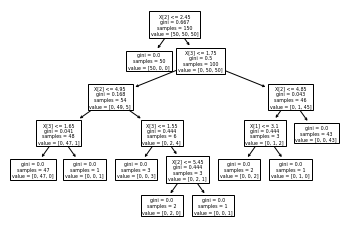

In [31]:
tree.plot_tree(clf)

In [32]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

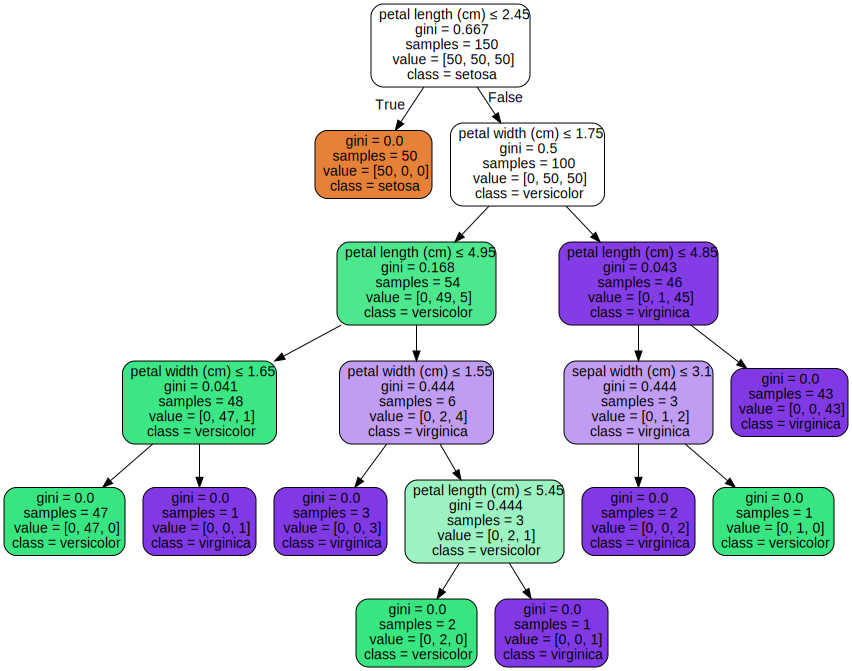

In [33]:
dot_data = tree.export_graphviz(clf, out_file=None, 
...                      feature_names=iris.feature_names,  
...                      class_names=iris.target_names,  
...                      filled=True, rounded=True,  
...                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [36]:
iris = load_iris()
decision_tree = DecisionTreeClassifier(random_state=0 ) #max_depth=2
decision_tree = decision_tree.fit(iris.data, iris.target)
r = export_text(decision_tree, feature_names=iris['feature_names'])
print(r)

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



In [42]:
penguins = pd.read_csv('peguins_classification.csv')
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"
penguins


,Culmen Length (mm),Culmen Depth (mm),Species
0,39.1,18.7,Adelie
1,39.5,17.4,Adelie
2,40.3,18.0,Adelie
3,36.7,19.3,Adelie
4,39.3,20.6,Adelie
...,...,...,...
337,55.8,19.8,Chinstrap
338,43.5,18.1,Chinstrap
339,49.6,18.2,Chinstrap
340,50.8,19.0,Chinstrap


In [44]:
penguins['Species']

0         Adelie
1         Adelie
2         Adelie
3         Adelie
4         Adelie
         ...    
337    Chinstrap
338    Chinstrap
339    Chinstrap
340    Chinstrap
341    Chinstrap
Name: Species, Length: 342, dtype: object

In [45]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

Create a decision tree classifier with a maximum depth of 2 levels and fit the training data. Once this classifier trained, plot the data and the decision boundary to see the benefit of increasing the depth. To plot the decision boundary, you should import the class DecisionBoundaryDisplay from the module helpers.plotting as shown in the previous course notebook.

In [47]:
# solution of the above question
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=2)

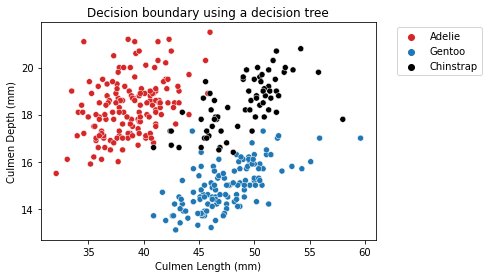

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns



palette = ["tab:red", "tab:blue", "black"]

ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a decision tree")

Did we make use of the feature “Culmen Length”? Plot the tree using the function sklearn.tree.plot_tree to find out!

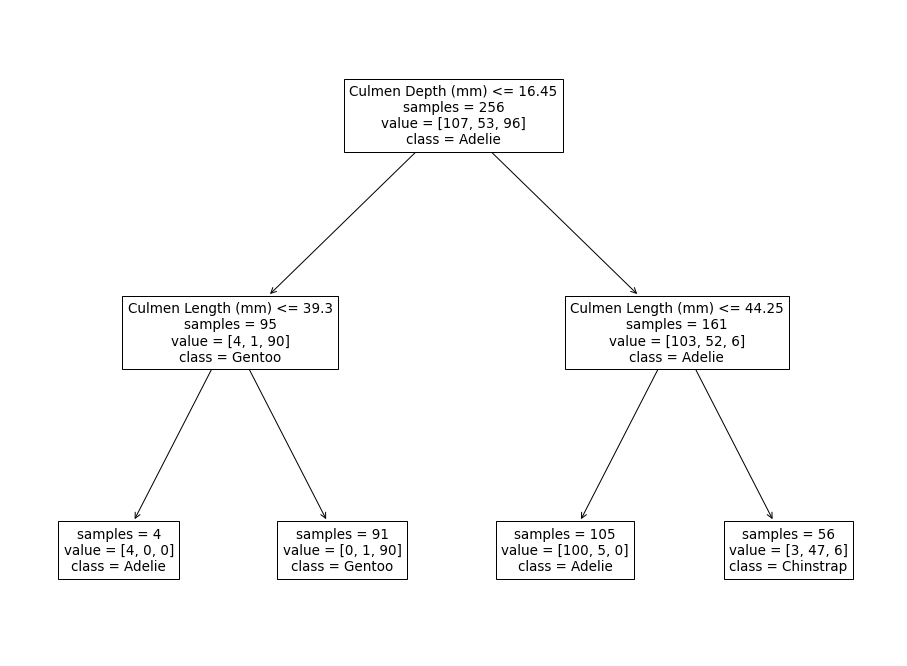

In [64]:
# solution
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=2)
tree=tree.fit(data_train,target_train)
_, ax = plt.subplots(figsize=(16, 12))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

Compute the accuracy of the decision tree on the testing data.

In [66]:
# solution
test_score = tree.fit(data_train, target_train).score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.97
